In [ ]:
!apt-get update

Hit:1 http://security.ubuntu.com/ubuntu bionic-security InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic 

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!wget -q https://downloads.apache.org/spark/spark-3.1.1/spark-3.1.1-bin-hadoop2.7.tgz

In [ ]:
!tar xf spark-3.1.1-bin-hadoop2.7.tgz

In [ ]:
!pip install -q findspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop2.7"

In [ ]:
import findspark
findspark.init()

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder\
        .master("local")\
        .appName("Collision")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

In [ ]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip -y ngrok-stable-linux-amd64.zip
get_ipython().system_raw('./ngrok http 4050 &')
!curl -s http://localhost:4040/api/tunnels

--2021-05-07 15:06:39--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 34.226.165.133, 52.202.162.45, 3.227.65.201, ...
Connecting to bin.equinox.io (bin.equinox.io)|34.226.165.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13832437 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.19M  57.4MB/s    in 0.2s    

2021-05-07 15:06:39 (57.4 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13832437/13832437]

UnZip 6.00 of 20 April 2009, by Debian. Original by Info-ZIP.

Usage: unzip [-Z] [-opts[modifiers]] file[.zip] [list] [-x xlist] [-d exdir]
  Default action is to extract files in list, except those in xlist, to exdir;
  file[.zip] may be a wildcard.  -Z => ZipInfo mode ("unzip -Z" for usage).

  -p  extract files to pipe, no messages     -l  list files (short format)
  -f  freshen existing files, create none    -t  te

In [ ]:
from pyspark import SparkContext,SparkConf
from pyspark.sql import SparkSession
import pyspark
conf = pyspark.SparkConf()
conf.set("spark.driver.memory","8G");
import numpy as np
sc = SparkContext.getOrCreate(conf=conf)
from pyspark.sql.functions import round, col
from pyspark.sql.types import DateType
from pyspark.sql.functions import to_date

In [ ]:
col = spark.read.option("header",True).csv("/content/drive/MyDrive/collision_cleaned.csv",inferSchema=True);

In [ ]:
col.cache()
col.printSchema()

root
 |-- CRASH DATE: string (nullable = true)
 |-- CRASH TIME: timestamp (nullable = true)
 |-- BOROUGH: string (nullable = true)
 |-- ZIP CODE: integer (nullable = true)
 |-- LATITUDE: double (nullable = true)
 |-- LONGITUDE: double (nullable = true)
 |-- LOCATION: string (nullable = true)
 |-- ON STREET NAME: string (nullable = true)
 |-- CROSS STREET NAME: string (nullable = true)
 |-- OFF STREET NAME: string (nullable = true)
 |-- NUMBER OF PERSONS INJURED: integer (nullable = true)
 |-- NUMBER OF PERSONS KILLED: integer (nullable = true)
 |-- NUMBER OF PEDESTRIANS INJURED: integer (nullable = true)
 |-- NUMBER OF PEDESTRIANS KILLED: integer (nullable = true)
 |-- NUMBER OF CYCLIST INJURED: integer (nullable = true)
 |-- NUMBER OF CYCLIST KILLED: integer (nullable = true)
 |-- NUMBER OF MOTORIST INJURED: integer (nullable = true)
 |-- NUMBER OF MOTORIST KILLED: integer (nullable = true)
 |-- CONTRIBUTING FACTOR VEHICLE 1: string (nullable = true)
 |-- CONTRIBUTING FACTOR VEHICLE 2

In [ ]:
col= col.withColumn('CRASH DATE',to_date(col["CRASH DATE"], 'MM/dd/yyyy'))

In [ ]:
### Removing YYYY-MM-DD from CRASH TIME
from pyspark.sql.types import DateType
from pyspark.sql.functions import date_format
from pyspark.sql import functions as f
col = col.withColumn("CRASH TIME", f.date_format("CRASH TIME", 'HH:mm:ss'))

In [ ]:
col = col.withColumn("CRASH TIME", f.date_format("CRASH TIME", 'HH:mm:ss'));
col= col.withColumn('CRASH DATE',to_date(col["CRASH DATE"], 'MM/dd/yyyy'))

In [ ]:
col.createOrReplaceTempView("col");

In [ ]:
data=spark.sql("select date_format(`CRASH TIME`,'H') as hour_ac,count(*) as count from col group by date_format(`CRASH TIME`, 'H') order by hour_ac asc")     

In [ ]:
import pandas as pd


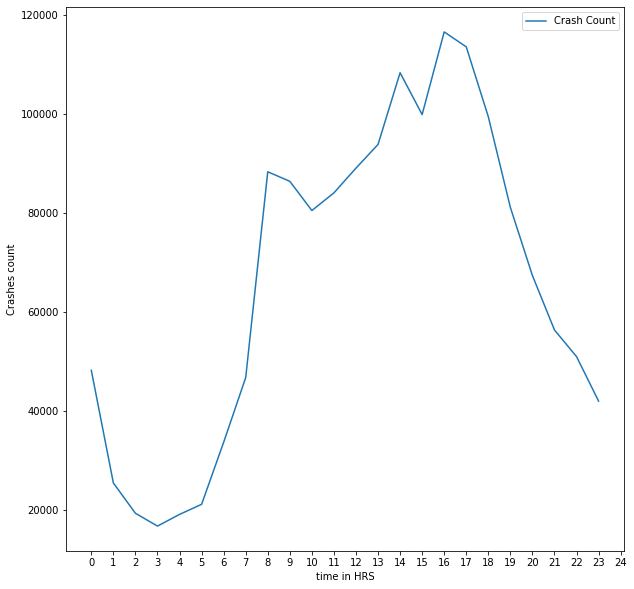

In [ ]:
df=pd.DataFrame(data.collect())
df[0] = pd.to_numeric(df[0])
df=df.sort_values(0);
pl=pd.DataFrame({
   'Crash Count': df[1].tolist(),
   }, index=df[0].tolist())
pl.plot(figsize=(10,10),xticks=range(0,25,1),xlabel="time in HRS",ylabel="Crashes count")

In [ ]:
collision_borough=spark.sql("select BOROUGH,count(BOROUGH) as count from col group by BOROUGH having BOROUGH is not null order by count");


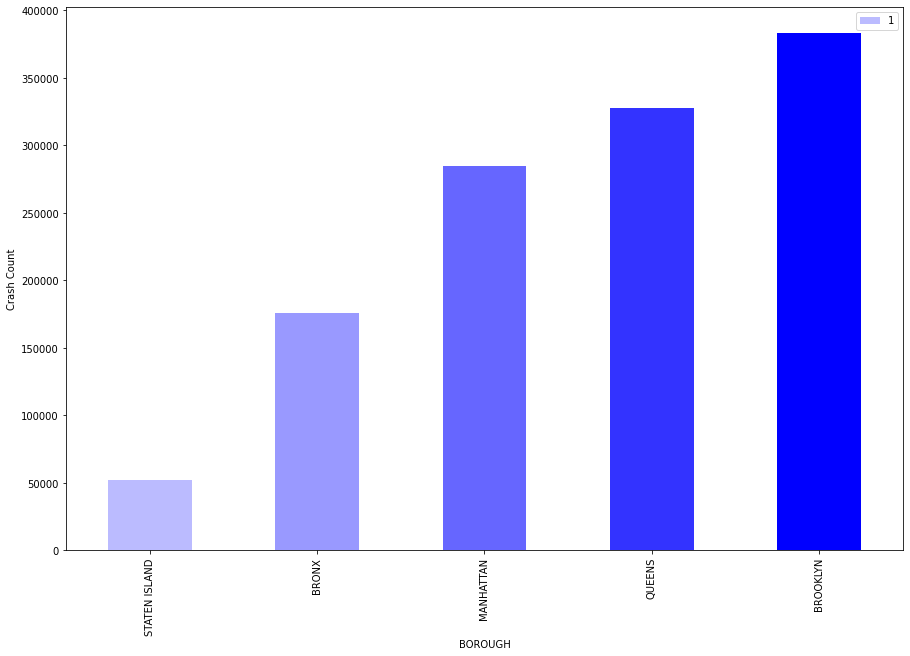

In [ ]:
pd.DataFrame(collision_borough.collect()).plot.bar(x=0,y=1,color=["#bbbbff","#9999ff","#6666ff","#3333ff","#0000ff"],figsize=(15,10)
                                                                                                          ,xlabel="BOROUGH",ylabel="Crash Count"      )


In [ ]:
collision_by_zip=spark.sql("select `ZIP CODE`,count(`ZIP CODE`) as Accidentcount from col group by `ZIP CODE` having `ZIP CODE` is not null ORDER BY Accidentcount desc limit 5");
collision_by_zip.show();

+--------+-------------+
|ZIP CODE|Accidentcount|
+--------+-------------+
|   11207|        22542|
|   11101|        16714|
|   11236|        15760|
|   10019|        15659|
|   11203|        15364|
+--------+-------------+



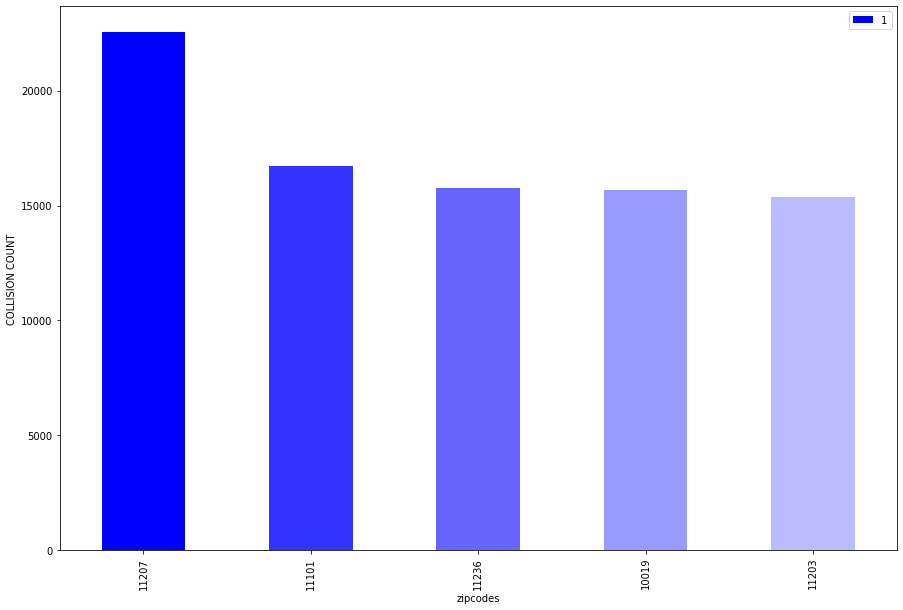

In [ ]:
pd.DataFrame(collision_by_zip.collect()).plot.bar(x=0,y=1,color=["#0000ff","#3333ff","#6666ff","#9999ff","#bbbbff"],figsize=(15,10),xlabel="zipcodes",ylabel="COLLISION COUNT");


In [ ]:
datayearly=spark.sql("select date_format(`CRASH DATE`,'y') as year, sum(`NUMBER OF PERSONS INJURED`) as injured, sum(`NUMBER OF PERSONS KILLED`) as killed from col group by year order by year");
     

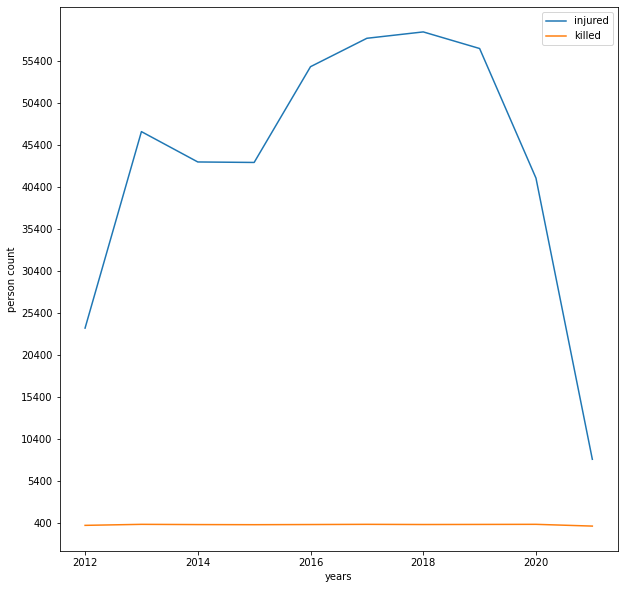

In [ ]:
df=pd.DataFrame(datayearly.collect())
df[1]
plo=pd.DataFrame({
   'injured': df[1].tolist(),
   'killed': df[2].tolist()
   }, index=df[0].tolist())
plo.plot(figsize=(10,10),yticks=range(400,60000,5000),xlabel="years",ylabel="person count")

In [ ]:
deadliestYearMonths=spark.sql("select DATE_FORMAT(`CRASH DATE`,'%d-%m-%Y'),sum(`NUMBER OF CYCLIST INJURED`) as injured from col group by col.`CRASH DATE` order by col.`CRASH DATE`  ");
     

In [ ]:
cyclist_injure_montly=spark.sql("select date_format(`CRASH DATE`,'L') as month,sum(`NUMBER OF CYCLIST INJURED`) as injured_cyclist from col group by month ");
     

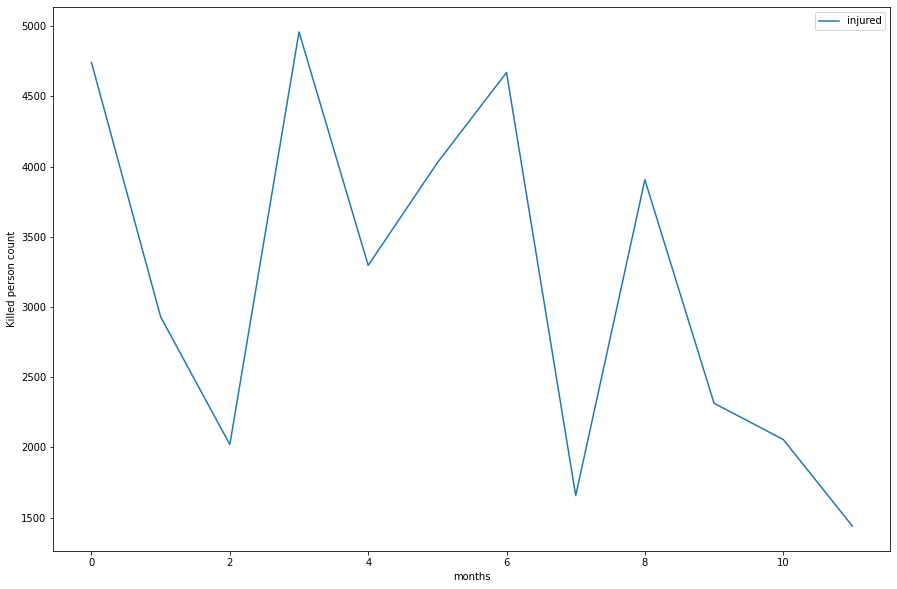

In [ ]:
df=pd.DataFrame(cyclist_injure_montly.collect());
plo=pd.DataFrame({
   'injured': df[1].tolist()
   }, index=df[0].tolist().sort() )

plo.plot.line(
    figsize=(15,10),
             xlabel="months",
             ylabel="Killed person count")

In [ ]:
data=spark.sql("select date_format(`CRASH TIME`,'H') as hour_ac,BOROUGH,count(*) as count from col group by date_format(`CRASH TIME`, 'H'),BOROUGH order by hour_ac asc")     

In [ ]:
dataBroughTime=spark.sql("select date_format(`CRASH TIME`,'H') as hour_ac,BOROUGH,count(*) as count from col where BOROUGH is not null group by date_format(`CRASH TIME`, 'H'),BOROUGH order by hour_ac asc")     

In [ ]:
dataBroughTime.show()


+-------+-------------+-----+
|hour_ac|      BOROUGH|count|
+-------+-------------+-----+
|      0|STATEN ISLAND| 1071|
|      0|     BROOKLYN|10919|
|      0|       QUEENS| 8412|
|      0|        BRONX| 5192|
|      0|    MANHATTAN| 9595|
|      1|        BRONX| 2677|
|      1|    MANHATTAN| 5524|
|      1|     BROOKLYN| 5598|
|      1|       QUEENS| 4450|
|      1|STATEN ISLAND|  603|
|     10|STATEN ISLAND| 2559|
|     10|     BROOKLYN|20186|
|     10|        BRONX| 8595|
|     10|       QUEENS|16165|
|     10|    MANHATTAN|15893|
|     11|     BROOKLYN|21012|
|     11|       QUEENS|16966|
|     11|    MANHATTAN|16783|
|     11|STATEN ISLAND| 2697|
|     11|        BRONX| 8908|
+-------+-------------+-----+
only showing top 20 rows



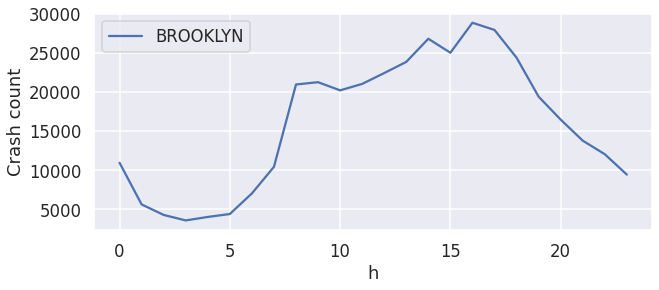

In [ ]:
df=pd.DataFrame(dataBroughTime.collect());
df=df.loc[df[1]=='BROOKLYN']
df[0] = pd.to_numeric(df[0]);
df=df.sort_values(0);
df[1].tolist()
plo=pd.DataFrame({
   'BROOKLYN': df[2].tolist()
   }, index=df[0].tolist())

plo.plot.line(
    figsize=(10,4),
             xlabel="h",
             ylabel="Crash count",
              label='BROOKLYN')
#BROOKLN

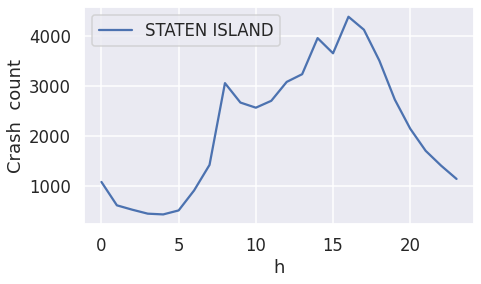

In [ ]:
df=pd.DataFrame(dataBroughTime.collect());
df=df.loc[df[1]=='STATEN ISLAND']
df[0] = pd.to_numeric(df[0]);
df=df.sort_values(0);
df[1].tolist()
plo=pd.DataFrame({
   'STATEN ISLAND': df[2].tolist()
   }, index=df[0].tolist())

plo.plot.line(
    figsize=(7,4),
             xlabel="h",
             ylabel="Crash  count",
              label='STATEN ISLAND')

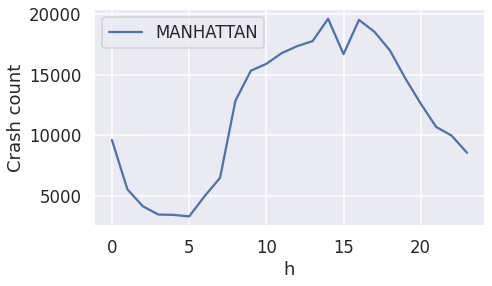

In [ ]:
df=pd.DataFrame(dataBroughTime.collect());
df=df.loc[df[1]=='MANHATTAN']
df[0] = pd.to_numeric(df[0]);
df=df.sort_values(0);
df[1].tolist()
plo=pd.DataFrame({
   'MANHATTAN': df[2].tolist()
   }, index=df[0].tolist())

plo.plot.line(
    figsize=(7,4),
             xlabel="h",
             ylabel="Crash count",
              label='MANHATTAN')
# MANHATTAN

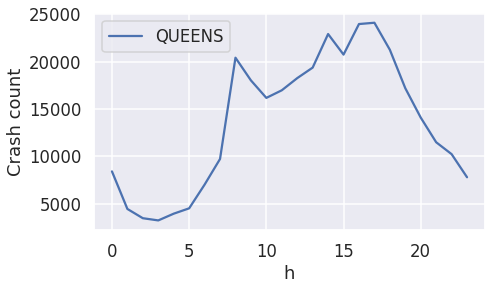

In [ ]:
df=pd.DataFrame(dataBroughTime.collect());
df=df.loc[df[1]=='QUEENS']
df[0] = pd.to_numeric(df[0]);
df=df.sort_values(0);
df[1].tolist()
plo=pd.DataFrame({
   'QUEENS': df[2].tolist()
   }, index=df[0].tolist())

plo.plot.line(
    figsize=(7,4),
             xlabel="h",
             ylabel="Crash count",
              label='QUEENS')

# QUEENS

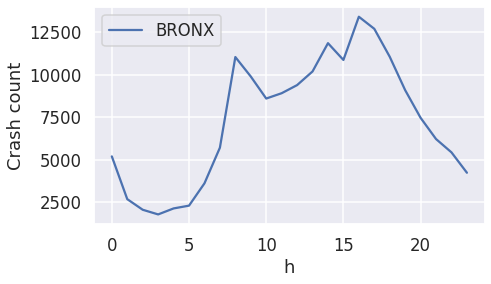

In [ ]:

df=pd.DataFrame(dataBroughTime.collect());
df=df.loc[df[1]=='BRONX']
df[0] = pd.to_numeric(df[0]);
df=df.sort_values(0);
df[1].tolist()
plo=pd.DataFrame({
   'BRONX': df[2].tolist()
   }, index=df[0].tolist())
plo.plot.line(
    figsize=(7,4),
             xlabel="h",
             ylabel="Crash count",
              label='QUEENS')
#QUEENS

In [ ]:
import seaborn as sns

In [ ]:
sns.set_theme()
sns.set_context("talk", font_scale=1.)


In [ ]:
import matplotlib.pyplot as plt

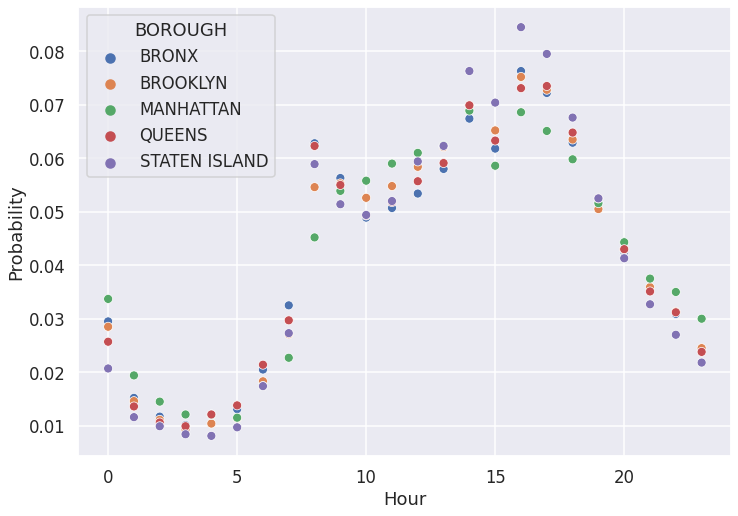

In [ ]:
data=spark.sql("select date_format(`CRASH TIME`,'H')as hour_ac ,BOROUGH, count(*) as Count from col where BOROUGH is not null group by hour_ac,BOROUGH")     
data.createOrReplaceTempView("data");
total=spark.sql("select BOROUGH, sum(Count) as totalCount from data group by BOROUGH");   
total.createOrReplaceTempView("total");  
final=spark.sql("select d.BOROUGH,d.hour_ac,round(d.Count/t.totalCount,4) as probability from data d join total t  on  d.BOROUGH=t.BOROUGH "); 
from pyspark.sql.types import IntegerType
final = final.withColumn("hour_ac", final["hour_ac"].cast(IntegerType()))
final=final.sort(final["hour_ac"],final["BOROUGH"])
import seaborn as sns
import matplotlib.pyplot as plt
dd=pd.DataFrame(final.collect());
dd.columns = ["BOROUGH", "Hour","Probability"]
sns.set_theme()
sns.set_context("talk", font_scale=1.)
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.scatterplot(data=dd,x="Hour", y="Probability",hue="BOROUGH")

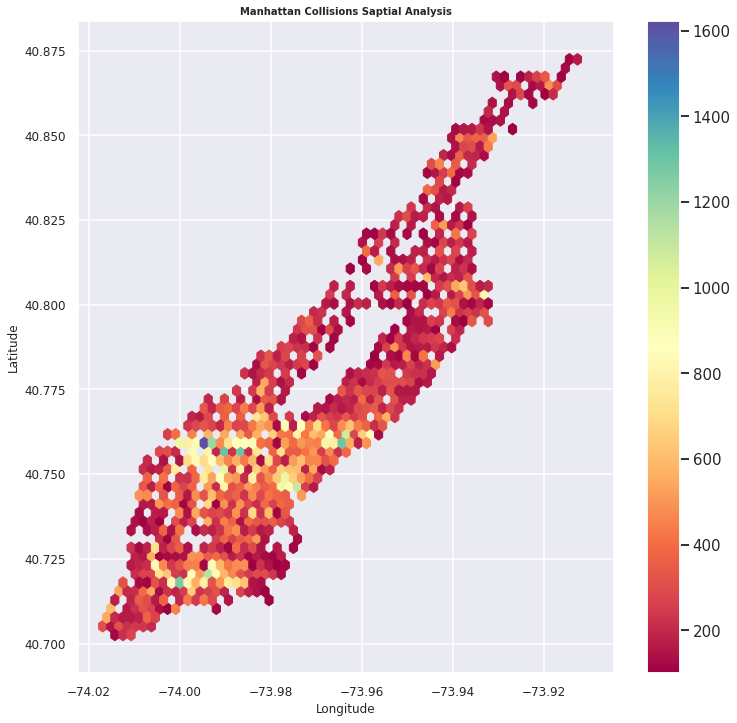

In [ ]:
import datetime
df=pd.DataFrame(col.select("CRASH DATE","ZIP CODE","LATITUDE","LONGITUDE","NUMBER OF PERSONS INJURED","NUMBER OF PERSONS KILLED").collect());
df.columns=["date",'zip_code',"latitude","longitude","number_of_persons_injured","number_of_persons_killed"]
df['year']=pd.DatetimeIndex(df["date"]).year
df.zip_code=pd.to_numeric(df.zip_code,
                          errors='coerce').fillna(0).astype(
                              np.int64
                              )
df_parv=df[(df["zip_code"]>10000)&(df["zip_code"]<10281)]
fig_hex,ax=plt.subplots(1,1,figsize=(12,12))
parv=ax.hexbin(y=df_parv["latitude"],x=df_parv["longitude"],
                      gridsize=60,cmap="Spectral",mincnt=100,
                      extent=(-74.017,-73.91,40.70,40.875)
                      )
cbar=fig.colorbar(parv,ax=ax)
cbar.ax.tick_params(labelsize=15)
ax.set_title("Manhattan Collisions Saptial Analysis", fontweight="bold", fontsize=10)
ax.tick_params(axis="x", labelsize=12)
ax.tick_params(axis="y", labelsize=12)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)
plt.show()

In [ ]:
import folium

In [ ]:
import folium # goelogical map
map_1 = folium.Map(location=[40.767937,-73.982155 ],tiles='OpenStreetMap',
 zoom_start=11.5)
df=pd.DataFrame(col.select("CRASH DATE","ZIP CODE","LATITUDE","LONGITUDE","NUMBER OF PERSONS INJURED","NUMBER OF PERSONS KILLED").collect());

df = df[df[2].notnull()]
df = df[df[3].notnull()]
for each in df[:3000].iterrows():
    folium.CircleMarker([each[1][2],each[1][3]],
                        radius=3,
                        color='red',
                        popup=str(each[1][2])+','+str(each[1][3]),
                        fill_color='#FD8A6C'
                        ).add_to(map_1)
map_1
